# housekeeping

In [1]:
import os
import time

import pandas as pd
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
import seaborn as sns

from xbart import XBART
from xbcausalforest import XBCF

# data

In [2]:
path = os.getcwd()  # works only in case it's launched from examples folder
fileloc = path + '/../GoalsAndGaps/Goals_new/dataset/others/dataset_causalforest.txt'
print(fileloc)

/Users/domolm/Library/CloudStorage/GoogleDrive-domokomod5@gmail.com/My Drive/Learning/研究計画/BCF_GAG/../GoalsAndGaps/Goals_new/dataset/others/dataset_causalforest.txt


In [3]:
df = pd.read_table(fileloc)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1217 entries, 0 to 1216
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   treat                      1217 non-null   int64  
 1   lictec2                    1217 non-null   int64  
 2   motivation                 687 non-null    float64
 3   barriers                   687 non-null    float64
 4   consiglio_lictec2          1217 non-null   int64  
 5   stdmatIII                  1094 non-null   float64
 6   stditaIII                  1094 non-null   float64
 7   school                     1217 non-null   int64  
 8   perc_participation_orient  597 non-null    float64
 9   perc_participation_calp    579 non-null    float64
 10  perc_participation         597 non-null    float64
 11  late                       1217 non-null   int64  
 12  female                     1217 non-null   int64  
 13  immigrato_prima_gen        1217 non-null   int64

In [4]:
# 処置や目的変数など
df.iloc[:, :11]

,treat,lictec2,motivation,barriers,consiglio_lictec2,stdmatIII,stditaIII,school,perc_participation_orient,perc_participation_calp,perc_participation
0,0,0,NaN,NaN,1,NaN,NaN,5,NaN,NaN,NaN
1,0,0,NaN,NaN,0,-1.399596,-1.555945,112,NaN,NaN,NaN
2,0,0,NaN,NaN,0,NaN,NaN,82,NaN,NaN,NaN
3,1,0,NaN,NaN,1,NaN,NaN,121,0.000000,0.000000,0.000000
4,1,0,NaN,NaN,0,-0.207511,-0.960164,115,0.384615,0.310345,0.333333
...,...,...,...,...,...,...,...,...,...,...,...
1212,0,1,-0.275965,0.035673,0,0.150114,-0.860868,131,NaN,NaN,NaN
1213,0,0,-0.794850,0.218068,0,-0.803554,-0.562978,112,NaN,NaN,NaN
1214,1,1,NaN,NaN,1,1.103783,0.529286,101,0.000000,0.000000,0.000000
1215,0,0,NaN,NaN,0,-1.161179,-0.265088,44,NaN,NaN,NaN


In [5]:
# 共変量
df.iloc[:,11:].head()

,late,female,immigrato_prima_gen,stdinvalsiI,stdinvalsiI_2,province,educmother,occmother,educfather,occfather,citizenship
0,0,1,1,-0.278840,0.077752,2,4,5,4,5,3
1,1,0,1,0.301034,0.090621,1,1,3,1,1,4
2,1,0,1,0.447595,0.200342,3,4,5,4,5,1
3,1,1,1,-0.247215,0.061115,4,4,5,4,5,1
4,0,1,1,-0.444550,0.197625,4,2,2,2,2,4


In [6]:
# xbcf 用に共変量の並びを変える
df_covar = \
df.reindex(
    columns=np.concatenate([
                df.iloc[:,14:16].columns.values,
                df.iloc[:,11:14].columns.values,
                df.iloc[:,16:].columns.values
            ])
)
df_covar

,stdinvalsiI,stdinvalsiI_2,late,female,immigrato_prima_gen,province,educmother,occmother,educfather,occfather,citizenship
0,-0.278840,0.077752,0,1,1,2,4,5,4,5,3
1,0.301034,0.090621,1,0,1,1,1,3,1,1,4
2,0.447595,0.200342,1,0,1,3,4,5,4,5,1
3,-0.247215,0.061115,1,1,1,4,4,5,4,5,1
4,-0.444550,0.197625,0,1,1,4,2,2,2,2,4
...,...,...,...,...,...,...,...,...,...,...,...
1212,-0.686664,0.471507,0,0,0,4,4,5,3,2,2
1213,-0.259723,0.067456,0,0,0,1,3,1,3,1,3
1214,0.810654,0.657160,0,0,1,3,2,2,2,2,4
1215,0.033399,0.001115,0,1,1,3,3,5,3,2,4


# XBCF

## 変数定義

In [7]:
y = df['lictec2'].to_numpy()
z = df['treat'].to_numpy()
X = df_covar.to_numpy()
z = z.astype(np.int32)

In [8]:
d_t = X.shape[1]
n = X.shape[0]

## propensity score 推定

In [9]:
start = time.time()
xbt = XBART(num_trees=100, num_sweeps=40, burnin=15)
xb_fit = xbt.fit_predict(X, z, X)
xb_fit = xb_fit.reshape((n, 1))

end = time.time()
print("second elapsed XBART for pihat: ", end - start)

second elapsed XBART for pihat:  1.4737589359283447


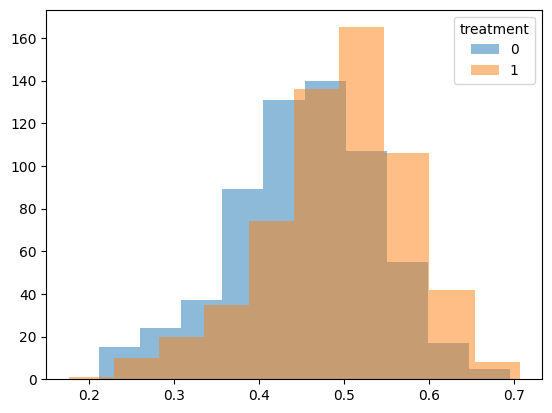

In [10]:
df_ps = pd.DataFrame({'ps':xb_fit.reshape(n,), 'treat':z})

for key, df in df_ps.groupby('treat'):
    color = 'Orange' if key == 1 else 'Blue'
    plt.hist(df['ps'], label=key, alpha=0.5)
plt.legend(title='treatment')

In [11]:
# append the fitted propensity scores to the original matrix
X1 = np.hstack((xb_fit, X))
d_p = X1.shape[1]

## fit

In [12]:
# XBCF parameters
sweeps = 10000
burn = 2000
p_cat = 9
trees_pr = 30
trees_trt = 10

In [13]:
# number of categorical variable are the only mandatory inputs
model = XBCF(
    num_sweeps=sweeps,
    burnin=burn,
    max_depth=250,
    num_trees_pr=trees_pr,
    num_trees_trt=trees_trt,
    mtry_pr=d_p,
    mtry_trt=d_t,
    num_cutpoints=100,
    Nmin=1,
    p_categorical_pr=p_cat,
    p_categorical_trt=p_cat,
    #tau_pr= 0.6 * np.var(y) / trees_pr,
    #tau_trt= 0.1 * np.var(y) / trees_trt,
    #no_split_penality="auto",
    #parallel=True,
    set_random_seed=True,
    random_seed=1013,
    #verbose=True, # 機能していない
    #standardize_target=False
)

In [14]:
start = time.time()
obj = model.fit(X, X1, y, z)
end = time.time()
print("seconds elapsed XBCF: ", end - start)

seconds elapsed XBCF:  152.49920010566711


## 結果

In [15]:
b = obj.b.transpose() # shape (2,sweeps)
a = obj.a.transpose() # shape (1,sweeps)

thats = obj.tauhats * (b[1] - b[0]) # shape (n, sweeps). これはobj.tauhats_adjusted と等価
thats_mean = np.mean(thats[:, (burn) : (sweeps - 1)], axis=1) # shape (n,)

# pseudo_ATE = np.mean(thats[:, (burn) : (sweeps - 1)], axis=0) # shape ((burn) : (sweeps - 1),)

# 結果可視化用の df を作成
df_vis = df_covar.copy()
df_vis['treat'] = z
df_vis['y'] = y
df_vis['tau'] = thats_mean

# # ATE 用
# pseudo_ATE_female = np.mean(thats[np.where(df_vis['female']==1), (burn) : (sweeps - 1)][0], axis=0) # shape (burn:sweep-1,)
# pseudo_ATE_male = np.mean(thats[np.where(df_vis['female']==0), (burn) : (sweeps - 1)][0], axis=0)

### pseudo ATE

In [16]:
# print(pseudo_ATE.mean())
# print(pseudo_ATE.std())
# plt.grid(alpha=0.5)
# plt.title('pseudo ATE')
# plt.hist(pseudo_ATE, bins='auto')

In [17]:
# print(pseudo_ATE_female.mean())
# print(pseudo_ATE_female.std())
# plt.title('female pseudo ATE')
# plt.grid(alpha=0.5)
# plt.hist(pseudo_ATE_female, bins='auto')

In [18]:
# print(pseudo_ATE_male.mean())
# print(pseudo_ATE_male.std())
# plt.title('male pseudo ATE')
# plt.grid(alpha=0.5)
# plt.hist(pseudo_ATE_male, bins='auto')

### CATE

0.024668972417404053
0.0010973084915709217


(array([  8.,  33., 121., 129., 153., 182., 102.,  99., 261., 129.]),
 array([0.0219303 , 0.02238366, 0.02283702, 0.02329039, 0.02374375,
        0.02419711, 0.02465048, 0.02510384, 0.0255572 , 0.02601057,
        0.02646393]),
 <BarContainer object of 10 artists>)

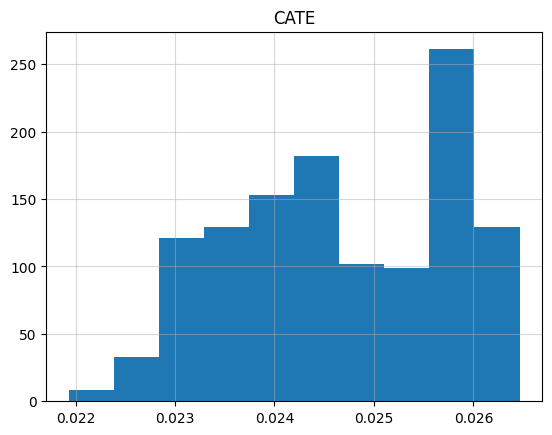

In [19]:
print(thats_mean.mean())
print(thats_mean.std())
plt.title('CATE')
plt.grid(alpha=0.5)
plt.hist(thats_mean)

Text(0.5, 1.0, 'CATE aggregated by gender')

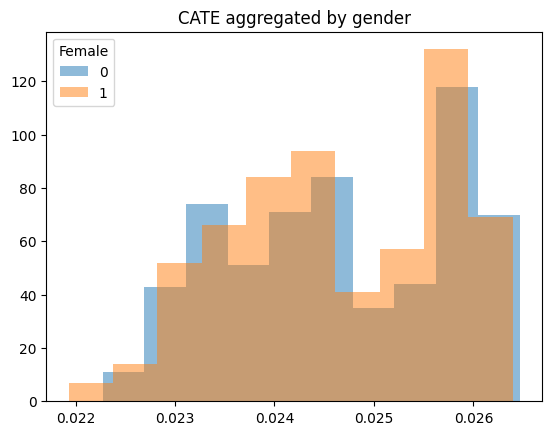

In [20]:
for key, df in df_vis.groupby('female'):
    color = 'Orange' if key==1 else 'Blue'
    plt.hist(df['tau'], label=key, alpha=0.5)

plt.legend(title='Female')
plt.title('CATE aggregated by gender')

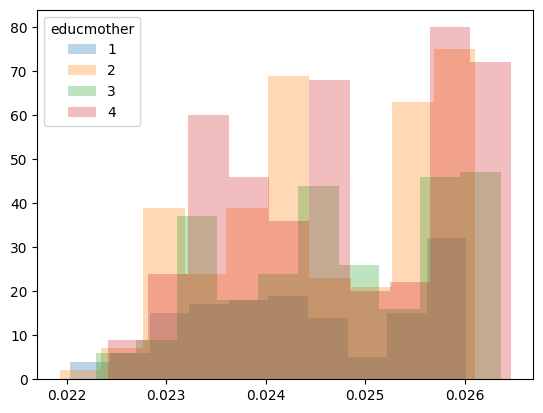

In [21]:
for key, df in df_vis.groupby('educmother'):
    color = 'Orange' if key==1 else 'Blue'
    plt.hist(df['tau'], label=key, alpha=0.3)

plt.legend(title='educmother')

Text(0.5, 1.0, 'Female')

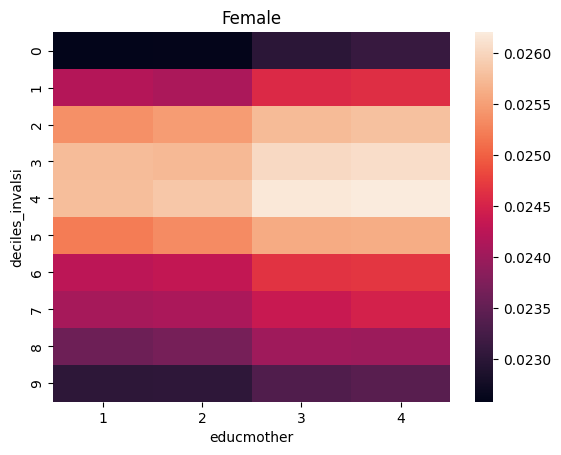

In [22]:
# heatmap
df_vis['deciles_invalsi'] = pd.qcut(df_vis['stdinvalsiI'], q=10, labels=False)
df_heatmap = pd.pivot_table(data=df_vis[df_vis['female']==1], index='deciles_invalsi', columns='educmother', values='tau')
sns.heatmap(df_heatmap)
plt.title('Female')

Text(0.5, 1.0, 'Male')

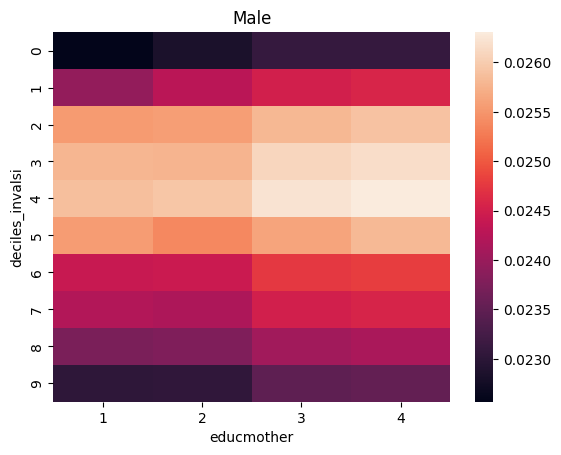

In [23]:
# heatmap
# df_vis['deciles_invalsi'] = pd.qcut(df_vis['stdinvalsiI'], q=10, labels=False)
df_heatmap = pd.pivot_table(data=df_vis[df_vis['female']==0], index='deciles_invalsi', columns='educmother', values='tau')
sns.heatmap(df_heatmap)
plt.title('Male')